In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from pathlib import Path
import sys


In [2]:
# get add the Base directory
BASE_DIR = str(Path().cwd().parent.resolve())
sys.path.insert(0, BASE_DIR)

In [3]:
df = pd.read_csv(f'{BASE_DIR}/data/fake_job_postings.csv', engine = 'python')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
only_fake = df[df['fraudulent'] == 1]
only_real = df[df['fraudulent'] == 0]

In [5]:
# 텍스트 데이터 분할 및 결측치 대체
text_df = df.iloc[:, [1,5,6,7,8,17]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [6]:
# 범주형 데이터 분할 및 결측치 대체
cat_df = df.iloc[:, 9:18]
cat_df = cat_df.fillna('None')

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [7]:
# 범주형 데이터 label 확인 (industry, function은 양이 많아서 생략)
for col in cat_df.iloc[:,3:6].columns:
  print('{}: {}'.format(col, cat_df[col].unique()))

employment_type: ['Other' 'Full-time' 'None' 'Part-time' 'Contract' 'Temporary']
required_experience: ['Internship' 'Not Applicable' 'None' 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']
required_education: ['None' "Bachelor's Degree" "Master's Degree" 'High School or equivalent'
 'Unspecified' 'Some College Coursework Completed' 'Vocational'
 'Certification' 'Associate Degree' 'Professional' 'Doctorate'
 'Some High School Coursework' 'Vocational - Degree'
 'Vocational - HS Diploma']


In [8]:
# 범주형 데이터 플롯 함수
def cat_label_plot(col, data, r1=0, r2=0, legend_label = ['Real', 'Fake'], stack=False, orient='v', label_bar=False):
  plt.figure(figsize = (10, 7))
  ax = plt.subplot(1,1,1)
  sns.set_palette('Set2')
  
  if not stack:  
    if orient == 'v':
      sns.countplot(x = col, data = data, hue = 'fraudulent', ax = ax)
      
    else:
      sns.countplot(y = col, data = data, hue = 'fraudulent', ax = ax)
    
  else:
    if orient == 'v':
      data.groupby([col, 'fraudulent']).size().unstack().plot(kind = 'bar', stacked = True, ax = ax)
    
    else:
      data.groupby([col, 'fraudulent']).size().unstack().plot(kind = 'barh', stacked = True, ax = ax)
    
  size = []
  for p in ax.patches:
    h = p.get_height()
    size.append(h)
    w = p.get_width()
    x = p.get_x()
    
    if label_bar:
      ax.text(x + w/2, h + 5, '{:1.2f}%'.format(h/len(data)*100), ha = 'center', rotation = r2)
    
  plt.title('{} distribution by fraudulent'.format(col))
  
  plt.setp(ax.xaxis.get_majorticklabels(), rotation = r1)
  plt.legend(labels = legend_label)
  plt.show()

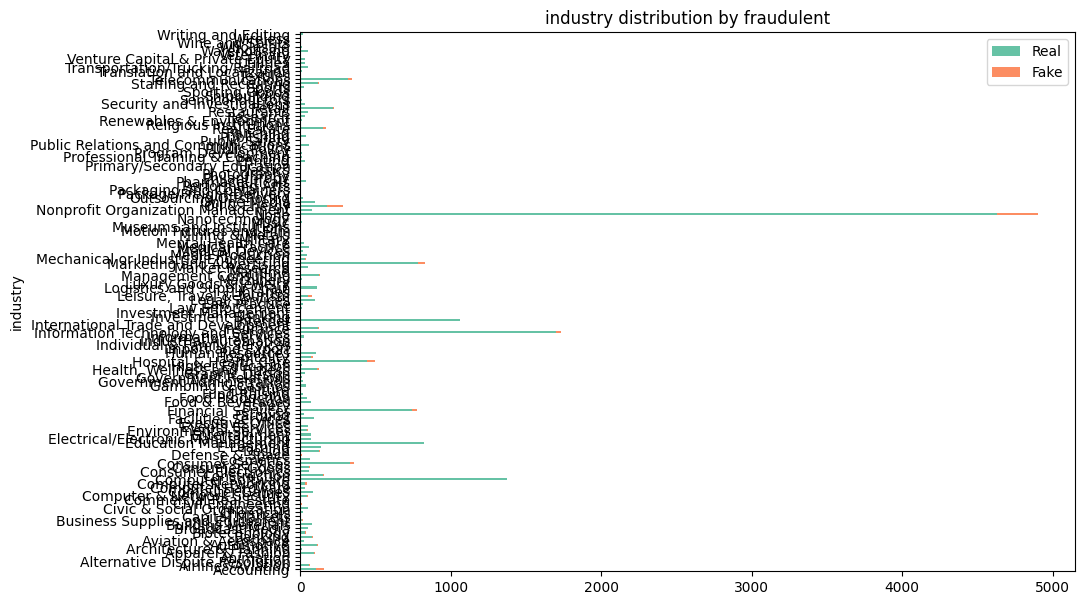

In [9]:
cat_label_plot('industry', cat_df, orient='h', stack=True)

위의 figure에서 볼 수 있듯이 하나의 figure에 담기에는 너무 많은 정보들이 존재함. 적당히 plot을 찍기 위해서 너무 소수로 존재하는 항목들은 data를 'None'으로 치환

In [10]:
# function to replace the values of colum. If the value is not in the given ratio, replace it with 'Other'

def replace_value(col, data, ratio):
    data = data.copy(deep = True)
    value = data[col].value_counts(normalize = True)
    replace = value[value < ratio].index
    data[col] = data[col].replace(replace, 'Other')
    return data

### Industry 분석

In [11]:
# industry의 unique 한 값들과 그 값들의 count 확인해보기

unique_industry = cat_df['industry'].unique()
unique_industry_count = cat_df['industry'].value_counts()
unique_industry_count.describe()

count     132.000000
mean      135.454545
std       483.524455
min         1.000000
25%         7.000000
50%        29.000000
75%        76.000000
max      4903.000000
Name: count, dtype: float64

In [12]:
# unique industry from only fake data

unique_industry_fake = only_fake['industry'].unique()
unique_industry_fake_count = only_fake['industry'].value_counts()
unique_industry_fake_count

industry
Oil & Energy                   109
Accounting                      57
Hospital & Health Care          51
Marketing and Advertising       45
Financial Services              35
                              ... 
Civic & Social Organization      1
Public Safety                    1
Wholesale                        1
Consumer Goods                   1
Online Media                     1
Name: count, Length: 62, dtype: int64

In [13]:
# unique industry from only real data
unique_industry_real = only_real['industry'].unique()
unique_industry_real_count = only_real['industry'].value_counts()
unique_industry_real_count

industry
Information Technology and Services    1702
Computer Software                      1371
Internet                               1062
Education Management                    822
Marketing and Advertising               783
                                       ... 
Museums and Institutions                  1
Sporting Goods                            1
Shipbuilding                              1
Alternative Dispute Resolution            1
Military                                  1
Name: count, Length: 130, dtype: int64

Fake와 real 데이터 간 industry 항목의 차이가 분명히 존재함

In [14]:
cat_df['industry'].value_counts()

industry
None                                   4903
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
                                       ... 
Shipbuilding                              1
Sporting Goods                            1
Museums and Institutions                  1
Wine and Spirits                          1
Ranching                                  1
Name: count, Length: 132, dtype: int64

In [15]:
replace_value('industry', cat_df, 0.015)['industry'].value_counts()

industry
None                                   4903
Other                                  4892
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Oil & Energy                            287
Name: count, dtype: int64

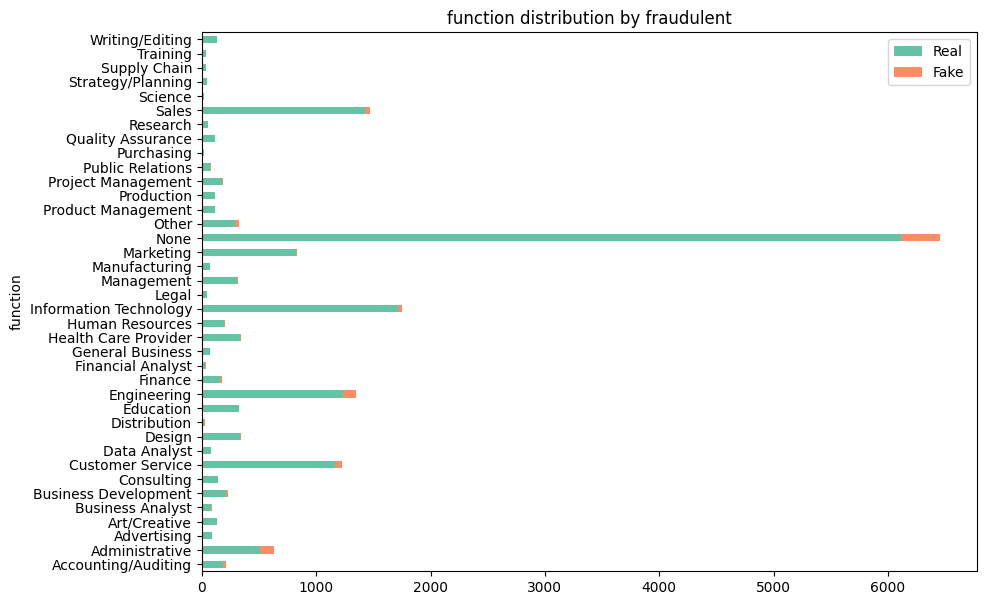

In [16]:
cat_label_plot('function', replace_value('industry', cat_df, 0.000001), r1=0, r2=90, stack=True, orient='h')

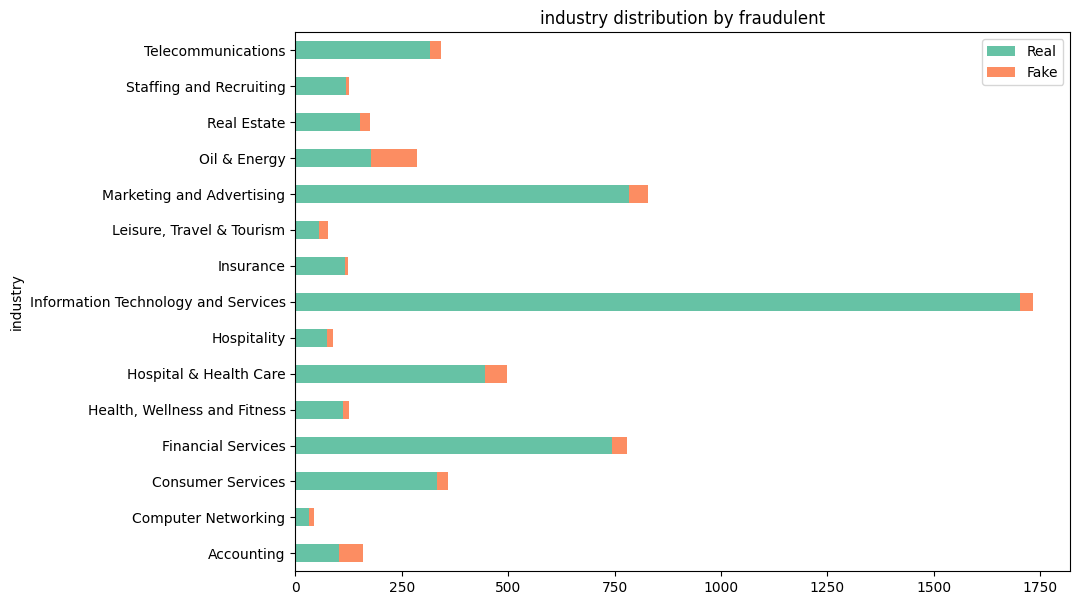

In [22]:
# only_fake에서 상위 10개의 industry에 대해서 원본 데이터를 가지고 plot 그려보기

top_10_industry_fake = only_fake['industry'].value_counts().head(15).index
top_10_industry_fake_mixed = cat_df[cat_df['industry'].isin(top_10_industry_fake)]
cat_label_plot('industry', top_10_industry_fake_mixed, r1=0, r2=90, stack=True, orient='h')

Industry가 'None'인 Fake job이 검출될 가능성이 다른 industry 보다 높다.

Engineering, Administrative, customer service에서 fake 검출이 비교적 높다

흥미로운 점은 기존 only_fake 데이터에서 상위에 rank된 industry 항목들 (Oil, hospital, etc.)은 위의 filtering을 한 번 한 표에는 충분한 샘플이 없는 관계로 집계되지 않음.

-> 이쪽 인코딩을 세 단계로 해보는 것은 어떨까?

i.e. 

0: Real job이 거의 대부분인 항목들 (writing, supply chain, management 등)

1: 해당 표에는 나타났는데 (= 어느정도 posting이 많이 생성되는데) fake의 비율이 좀 높은 항목들 (Engineering, Administrative, customer service 등)

2: 해당 표에는 없는데 그냥 fake job이 많이 올라온 항목들 (Oil, hospital 등)

숫자가 커질 수록 해당 industry에 fake job이 올라올 가능성이 높음을 의미하는 ordinal value